<a href="https://colab.research.google.com/github/fbeilstein/dbms/blob/master/DB_lecture_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Buffer Management**


Most databases are built using a two-level memory hierarchy: 
* slower persistent storage (disk) and 
* faster main memory (RAM). 

To reduce the number of accesses to persistent storage, pages are **cached** in memory. When the page is requested again by the storage layer, its cached copy is returned.

Cached pages available in memory can be reused under the assumption that no other process has modified the data on disk. This approach is sometimes referenced as **virtual disk**. 

A virtual disk read accesses physical storage only if no copy of the page is already available in memory. A more common name for the same concept is **page cache** or **buffer pool**. The page cache is responsible for caching pages read from disk in memory. In case of a database system crash or unorderly shutdown, cached contents are lost.

The problem of caching pages is not limited in scope to databases. Operating systems have the concept of a page cache, too. Operating systems utilize unused memory segments to transparently cache disk contents to improve performance of I/O syscalls.

Uncached pages are said to be **paged in** when they’re loaded from disk. If any changes are made to the cached page, it is said to be **dirty**, until these changes are flushed back on disk.

Since the memory region where cached pages are held is usually substantially smaller than an entire dataset, the page cache eventually fills up and, in order to page in a new page, one of the cached pages has to be evicted.

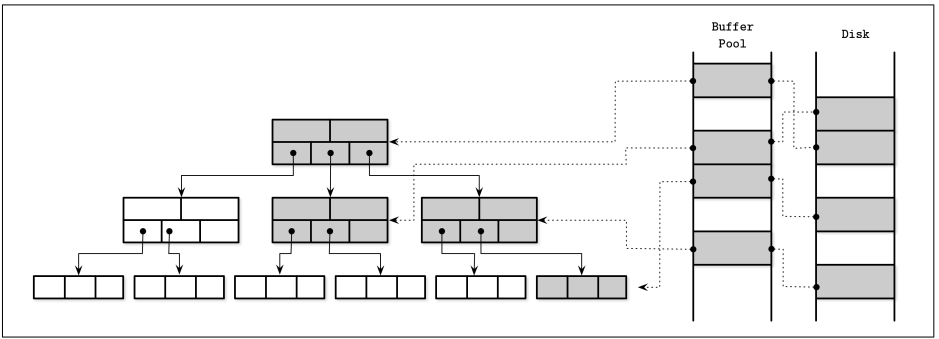

The primary functions of a page cache can be summarized as:
* It keeps cached page contents in memory.
* It allows modifications to on-disk pages to be buffered together and performed
against their cached versions.
* When a requested page isn’t present in memory and there’s enough space avail‐
able for it, it is paged in by the page cache, and its cached version is returned.
* If an already cached page is requested, its cached version is returned.
* If there’s not enough space available for the new page, some other page is evicted and its contents are flushed to disk

**Bypassing the Kernel Page Cache**

Many database systems open files using `O_DIRECT` flag. This flag allows I/O system calls to bypass the kernel page cache, access the disk directly, and use databasespecific buffer management. This is sometimes frowned upon by the operating systems folks.

Linus Torvalds has criticized usage of `O_DIRECT` since it’s not asynchronous and has no readahead or other means for instructing the kernel about access patterns. However, until operating systems start offering better mechanisms, `O_DIRECT` is still going to be useful.

We can gain some control over how the kernel evicts pages from its cache is by using `fadvise`, but this only allows us to ask the kernel to consider our opinion and does not guarantee it will actually happen. To avoid syscalls when performing I/O, we can use memory mapping, but then we lose control over caching.

**Caching Semantics**

All changes made to buffers are kept in memory until they are eventually written
back to disk. As no other process is allowed to make changes to the backing file, this synchronization is a one-way process: from memory to disk, and not vice versa. 

The page cache allows the database to have more control over memory management and disk accesses. You can think of it as an application-specific equivalent of the kernel page cache: it accesses the block device directly, implements similar functionality, and serves a similar purpose. It abstracts disk accesses and decouples logical write operations from the physical ones.

Caching pages helps to keep the tree partially in memory without making additional changes to the algorithm and materializing objects in memory. All we have to do is replace disk accesses by the calls to the page cache.

* When the storage engine accesses (in other words, requests) the page, we first check if its contents are already cached, in which case the cached page contents are returned. 
* If the page contents are not yet cached, the cache translates the logical page address or page number to its physical address, loads its contents in memory, and returns its cached version to the storage engine. 
* Once returned, the buffer with cached page contents is said to be referenced, and the storage engine has to hand it back to the page cache or dereference it once it’s done. 

The page cache can be instructed to avoid evicting pages by pinning them.

If the page is modified (for example, a cell was appended to it), it is marked as dirty. A dirty flag set on the page indicates that its contents are out of sync with the disk and have to be flushed for durability.

**Cache Eviction**


Keeping caches populated is good: we can serve more reads without going to persistent storage, and more same-page writes can be buffered together. 

However, the page cache has a limited capacity and, sooner or later, to serve the new contents, old pages have to be **evicted**. 
* If page contents are in sync with the disk (i.e., were already flushed or were never modified) and the page is not pinned or referenced, it can be evicted right away. 
* Dirty pages have to be flushed before they can be evicted. 
* Referenced pages should not be evicted while some other thread is using them.

Since triggering a flush on every eviction might be bad for performance, some databases use a separate background process that cycles through the dirty pages that are likely to be evicted, updating their disk versions. For example, **PostgreSQL** has a background flush writer that does just that.

Another important property to keep in mind is durability: if the database has crashed, all data that was not flushed is lost. To make sure that all changes are persisted, flushes are coordinated by the **checkpoint process**. The checkpoint process controls the write-ahead log (WAL) and page cache, and ensures that they work in lockstep.

Only log records associated with operations applied to cached pages that were flushed can be discarded from the WAL. Dirty pages cannot be evicted until this process completes.

This means there is always a trade-off between several objectives:
* Postpone flushes to reduce the number of disk accesses
* Preemptively flush pages to allow quick eviction
* Pick pages for eviction and flush in the optimal order
* Keep cache size within its memory bounds
* Avoid losing the data as it is not persisted to the primary storage

We explore several techniques that help us to improve the first three characteristics while keeping us within the boundaries of the other two

**Locking Pages in Cache**


Having to perform disk I/O on each read or write is impractical: subsequent reads may request the same page, just as subsequent writes may modify the same page.

Since B-Tree gets “narrower” toward the top, higher-level nodes (ones that are closer to the root) are hit for most of the reads. Splits and merges also eventually propagate to the higher-level nodes. This means there’s always at least a part of a tree that can significantly benefit from being cached.

We can **“lock”** pages that have a high probability of being used in the nearest time.

Locking pages in the cache is called **pinning**. Pinned pages are kept in memory for a longer time, which helps to reduce the number of disk accesses and improve performance.

Since each lower B-Tree node level has exponentially more nodes than the higher
one, and higher-level nodes represent just a small fraction of the tree, this part of the tree can reside in memory permanently, and other parts can be paged in on demand.

This means that, in order to perform a query, we won’t have to make h disk accesses but only hit the disk for the lower levels, for which pages are not cached.

Operations performed against a subtree may result in structural changes that contradict each other—for example, multiple delete operations causing merges followed by writes causing splits, or vice versa. Likewise for structural changes that propagate from different subtrees (structural changes occurring close to each other in time, in different parts of the tree, propagating up). These operations can be buffered together by applying changes only in memory, which can reduce the number of disk writes and amortize the operation costs, since only one write can be performed instead of multiple writes.

**Prefetching and Immediate Eviction**

The page cache also allows the storage engine to have fine-grained control over prefetching and eviction. It can be instructed to load pages ahead of time, before they are accessed. For example, when the leaf nodes are traversed in a range scan, the next leaves can be preloaded. Similarly, if a maintenance process loads the page, it can be evicted immediately after the process finishes, since it’s unlikely to be useful for the in-flight queries. Some databases, for example, PostgreSQL, use a circular buffer (in other words, FIFO page replacement policy) for large sequential scans.

**Page Replacement**

When cache capacity is reached, to load new pages, old ones have to be evicted. 

However, unless we evict pages that are least likely to be accessed again soon, we might end up loading them several times subsequently even though we could’ve just kept them in memory for all that time. We need to find a way to estimate the likelihood of subsequent page access to optimize this.

For this, we can say that pages should be evicted according to the **eviction policy** (also sometimes called the page-replacement policy). It attempts to find pages that are least likely to be accessed again any time soon. When the page is evicted from the cache, the new page can be loaded in its place.

For a page cache implementation to be performant, it needs an efficient pagereplacement algorithm. An ideal page-replacement strategy would require a crystal ball that would predict the order in which pages are going to be accessed and evict only pages that will not be touched for the longest time. Since requests do not necessarily follow any specific pattern or distribution, precisely predicting behavior can be complicated, but using a right page replacement strategy can help to reduce the number of evictions.

It seems logical that we can reduce the number of evictions by simply using a larger cache. However, this does not appear to be the case. One of the examples demonstrating this dilemma this is called [**Bélády’s anomaly**](https://en.wikipedia.org/wiki/B%C3%A9l%C3%A1dy%27s_anomaly). It shows that increasing the number of pages might increase the number of evictions if the used pagereplacement algorithm is not optimal. When pages that might be required soon are evicted and then loaded again, pages start competing for space in the cache. Because of that, we need to wisely consider the algorithm we’re using, so that it would improve the situation, not make it worse.

**FIFO and LRU**


The most naïve page-replacement strategy is **first in, first out** (FIFO). FIFO maintains a queue of page IDs in their insertion order, adding new pages to the tail of the queue.

Whenever the page cache is full, it takes the element from the head of the queue to find the page that was paged in at the farthest point in time. Since it does not account for subsequent page accesses, only for page-in events, this proves to be impractical for the most real-world systems. For example, the root and topmost-level pages are paged in first and, according to this algorithm, are the first candidates for eviction, even though it’s clear from the tree structure that these pages are likely to paged in again soon, if not immediately.

A natural extension of the FIFO algorithm is **least-recently used** (LRU). It also maintains a queue of eviction candidates in insertion order, but
allows you to place a page back to the tail of the queue on repeated accesses, as if this was the first time it was paged in. However, updating references and relinking nodes on every access can become expensive in a concurrent environment.

There are other LRU-based cache eviction strategies. For example, 2Q (Two-Queue
LRU) maintains two queues and puts pages into the first queue during the initial
access and moves them to the second hot queue on subsequent accesses, allowing you to distinguish between the recently and frequently accessed pages.

LRU-K identifies frequently referenced pages by keeping track of the last K accesses, and using this information to estimate access times on a page basis.

**CLOCK**

In some situations, efficiency may be more important than precision. CLOCK algorithm variants are often used as compact, cache-friendly, and concurrent alternatives to LRU. 

Linux, for example, uses a variant of the CLOCK algorithm.

CLOCK-sweep holds references to pages and associated access bits in a circular
buffer. Some variants use counters instead of bits to account for frequency. **Every time the page is accessed, its access bit is set to 1**. The algorithm works by going around the circular buffer, checking access bits:
* If the access bit is 1, and the page is unreferenced, it is set to 0, and the next page is inspected.
* If the access bit is already 0, the page becomes a candidate and is scheduled for eviction.
* If the page is currently referenced, its access bit remains unchanged. It is assumed that the access bit of an accessed page cannot be 0, so it cannot be evicted. This makes referenced pages less likely to be replaced.

An advantage of using a circular buffer is that both the clock hand pointer and contents can be modified using [**compare-and-swap**](https://en.wikipedia.org/wiki/Compare-and-swap) operations, and do not require additional locking mechanisms. The algorithm is easy to understand and implement and is often used in both textbooks and real-wold systems.

LRU is not always the best replacement strategy for a database system. Sometimes, it may be more practical to consider usage frequency rather than recency as a predictive factor. In the end, for a database system under a heavy load, recency might not be very indicative as it only represents the order in which items were accessed.

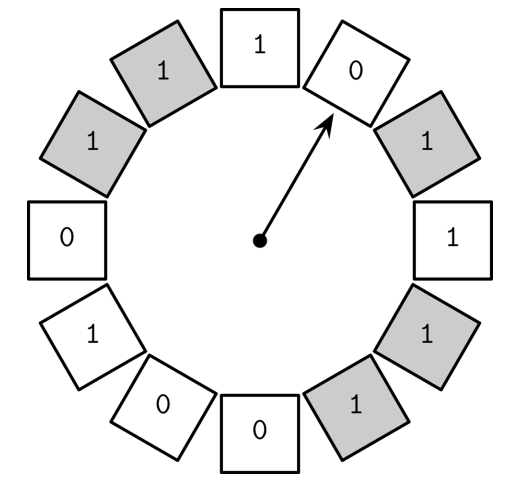

**LFU**

To improve the situation, we can start tracking **page reference events** rather than pagein events. One of the approaches allowing us to do this tracks **least-frequently used** (LFU) pages.

[TinyLFU](https://arxiv.org/pdf/1512.00727.pdf), a frequency-based page-eviction policy, does precisely this: instead of evicting pages based on page-in recency, it orders pages by usage frequency. It is implemented in the popular Java library called Caffeine.

TinyLFU uses a frequency histogram to maintain compact cache access history, since preserving an entire history might be prohibitively expensive for
practical purposes.

Elements can be in one of the three **queues**:
* Admission, maintaining newly added elements, implemented using LRU policy.
* Probation, holding elements most likely to get evicted.
* Protected, holding elements that are to stay in the queue for a longer time.

Rather than choosing which elements to evict every time, this approach chooses
which ones to promote for retention. 

Only the items that have a frequency larger than the item that would be evicted as a result of promoting them, can be moved to the probation queue. 

On subsequent accesses, items can get moved from probation to the protected queue. If the protected queue is full, one of the elements from it may have to be placed back into probation. 

More frequently accessed items have a higher chance of retention, and less frequently used ones are more likely to be evicted. There are many other algorithms that can be used for optimal cache eviction. The choice of a page-replacement strategy has a significant impact on latency and the number of performed I/O operations, and has to be taken into consideration.

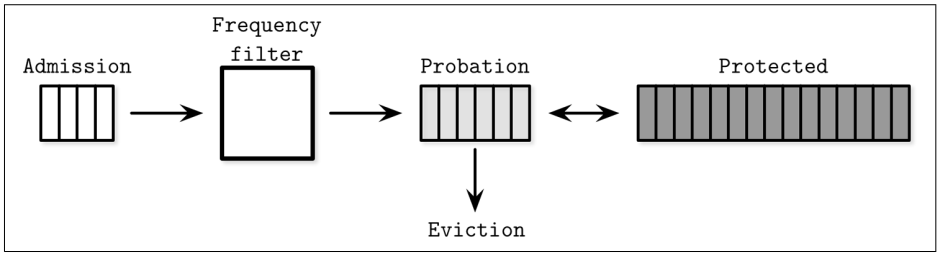

**Recovery**

Database systems are built on top of several hardware and software layers that can have their own stability and reliability problems. Database systems themselves, as well as the underlying software and hardware components, may fail. Database implementers have to consider these failure scenarios and make sure that the data that was “promised” to be written is, in fact, written.

A **write-ahead log** (WAL for short, also known as a commit log) is an append-only auxiliary disk-resident structure used for crash and transaction recovery. The page cache allows buffering changes to page contents in memory. Until the cached contents are flushed back to disk, the only disk-resident copy preserving the operation history is stored in the WAL. Many database systems use **append-only write-ahead logs**; for example, **PostgreSQL** and **MySQL**.

The main functionality of a write-ahead log can be summarized as:
* Allow the page cache to buffer updates to disk-resident pages while ensuring
durability semantics in the larger context of a database system.
* Persist all operations on disk until the cached copies of pages affected by these operations are synchronized on disk. Every operation that modifies the database state has to be logged on disk before the contents of the associated pages can be modified.
* Allow lost in-memory changes to be reconstructed from the operation log in case of a crash.

In addition to this functionality, the write-ahead log plays an important role in transaction processing. It is hard to overstate the importance of the WAL as it ensures that data makes it to the persistent storage and is available in case of a crash, as uncommitted data is replayed from the log and the pre-crash database state is fully restored.

**PostgreSQL Versus fsync()**

PostgreSQL uses **checkpoints** to ensure that index and data files have been updated with all information up to a certain record in the logfile. Flushing all dirty (modified) pages at once is done periodically by the checkpoint process. 

Synchronizing dirty page contents with disk is done by making the fsync() kernel call, which is supposed to sync dirty pages to disk, and unset the dirty flag on the kernel pages. As you would expect, fsync returns with an error if it isn’t able to flush pages on disk.

In **Linux** and a few other operating systems, fsync unsets the dirty flag even from **unsuccessfully** flushed pages after I/O errors. Additionally, errors will be reported only to the file descriptors that were open at the time of failure, so fsync will not return any errors that have occurred before the descriptor it was called upon was opened.

Since the checkpointer doesn’t keep all files open at any given point in time, it may happen that it misses error notifications. Because dirty page flags are cleared, the checkpointer will assume that data has successfully made it on disk while, in fact, it might have not been written.

A combination of these behaviors can be a source of data loss or database corruption in the presence of potentially recoverable failures. Such behaviors can be difficult to detect and some of the states they lead to may be unrecoverable. Sometimes, even triggering such behavior can be nontrivial. When working on recovery mechanisms, we should always take extra care and think through and attempt to test every possible failure scenario.

**Log Semantics**

The write-ahead log is **append-only** and its written contents are **immutable**, so all writes to the log are sequential. Since the **WAL** is an immutable, append-only data structure, readers can safely access its contents up to the latest write threshold while the writer continues appending data to the log tail.

The WAL consists of log records. Every record has a unique, monotonically increasing **log sequence number** (LSN). Usually, the LSN is represented by an internal counter or a timestamp. Since log records do not necessarily occupy an entire disk block, their contents are cached in the log buffer and are flushed on disk in a **force operation**.

Forces happen as the log buffers fill up, and can be requested by the transaction manager or a page cache. All log records have to be flushed on disk in LSN order.

Besides individual operation records, the WAL holds records indicating **transaction completion**. A transaction can’t be considered committed until the log is forced up to the LSN of its commit record. To make sure the system can continue functioning correctly after a crash during rollback or recovery, some systems use compensation log records (CLR) during undo and store them in the log.

The WAL is usually coupled with a primary storage structure by the interface that **allows trimming** it whenever a checkpoint is reached. Logging is one of the most critical correctness aspects of the database, which is somewhat tricky to get right: even the slightest disagreements between log trimming and ensuring that the data has made it to the primary storage structure may cause data loss.

**Checkpoints** are a way for a log to know that log records up to a certain mark are fully persisted and aren’t required anymore, which significantly reduces the amount of work required during the database startup. A process that forces all dirty pages to be flushed on disk is generally called a sync checkpoint, as it fully synchronizes the primary storage structure.

Flushing the entire contents on disk is rather impractical and would require pausing all running operations until the checkpoint is done, so most database systems implement **fuzzy checkpoints**. In this case, the `last_checkpoint` pointer stored in the log header contains the information about the last successful checkpoint. A fuzzy checkpoint begins with a special `begin_checkpoint` log record specifying its start, and ends with `end_checkpoint` log record, containing information about the dirty pages, and
the contents of a transaction table. Until all the pages specified by this record are flushed, the checkpoint is considered to be incomplete. Pages are flushed asynchronously and, once this is done, the last_checkpoint record is updated with the LSN of the `begin_checkpoint` record and, in case of a crash, the recovery process will start from there.

**Operation Versus Data Log**


Some database systems, for example **System R**, use **shadow paging**: a copy-on-write technique ensuring data durability and transaction atomicity.

**New contents** are placed into the new unpublished **shadow page** and made visible with a pointer flip, from the old page to the one holding updated contents.

Any state change can be represented by a before-image and an after-image or by corresponding redo and undo operations. Applying a redo operation to a before-image produces an after-image. Similarly, applying an undo operation to an after-image produces a before-image.

We can use a **physical log** (that stores complete page state or byte-wise changes to it) or a **logical log** (that stores operations that have to be performed against the current state) to move records or pages from one state to the other, both backward and forward in time. 

It is important to track the exact state of the pages that physical and
logical log records can be applied to.

Physical logging records before and after images, requiring entire pages affected by the operation to be logged. A logical log specifies which operations have to be applied to the page, such as "insert a data record X for key Y", and a corresponding undo operation, such as "remove the value associated with Y".

In practice, many database systems use a combination of these two approaches, using logical logging to perform an undo (for concurrency and performance) and physical logging to perform a redo (to improve recovery time).

**Steal and Force Policies**

To determine when the changes made in memory have to be flushed on disk, database management systems define **steal/no-steal** and **force/no-force** policies. 

These policies are mostly applicable to the page cache, but they’re better discussed in the context of recovery, since they have a significant impact on which recovery approaches can be used in combination with them.

A recovery method that allows **flushing** a page modified by the transaction even **before** the transaction has **committed** is called a **steal policy**. A no-steal policy does not allow flushing any uncommitted transaction contents on disk. To steal a **dirty** page here means flushing its in-memory contents to disk and loading a different page from disk in its place.

A **force policy** requires all pages modified by the transactions to be flushed on disk before the transaction commits. On the other hand, a **no-force policy** allows a transaction to commit even if some pages modified during this transaction were not yet flushed on disk. To force a dirty page here means to flush it on disk before the commit.


Steal and force policies are important to understand, since they have implications for transaction undo and redo. Undo rolls back updates to forced pages for committed transactions, while redo applies changes performed by committed transactions on disk.

Using the **no-steal policy** allows implementing recovery using **only redo** entries: old copy is contained in the page on disk and modification is stored in the log. With **no-force**, we potentially can buffer several updates to pages by deferring them. Since page contents have to be cached in memory for that time, a larger page cache may be needed.

When the force policy is used, crash recovery doesn’t need any additional work to reconstruct the results of committed transactions, since pages modified by these transactions are already flushed. A major drawback of using this approach is that transactions take longer to commit due to the necessary I/O.

More generally, until the transaction commits, we need to have enough information to undo its results. If any pages touched by the transaction are flushed, we need to keep undo information in the log until it commits to be able to roll it back. Otherwise, we have to keep redo records in the log until it commits. In both cases, transaction cannot commit until either undo or redo records are written to the logfile.

**ARIES**

ARIES is a **steal/no-force** recovery algorithm. It uses **physical redo** to improve performance during recovery (since changes can be installed quicker) and **logical undo** to improve concurrency during normal operation (since logical undo operations can be applied to pages independently). It uses **WAL records** to implement repeating history during recovery, to completely reconstruct the database state before undoing uncommitted transactions, and creates compensation log records during undo .

When the database system restarts after the crash, recovery proceeds in three phases:
1. The analysis phase identifies dirty pages in the page cache and transactions that were in progress at the time of a crash. Information about dirty pages is used to identify the starting point for the redo phase. A list of in-progress transactions is used during the undo phase to roll back incomplete transactions.
2. The redo phase repeats the history up to the point of a crash and restores the database to the previous state. This phase is done for incomplete transactions as well as ones that were committed but whose contents weren’t flushed to persistent storage.
3. The undo phase rolls back all incomplete transactions and restores the database to the last consistent state. All operations are rolled back in reverse chronological order. In case the database crashes again during recovery, operations that undo transactions are logged as well to avoid repeating them.

ARIES uses LSNs for identifying log records, tracks pages modified by running transactions in the dirty page table, and uses physical redo, logical undo, and fuzzy checkpointing. Even though the paper describing this system was released in 1992, most concepts, approaches, and paradigms are still relevant in transaction processing and recovery today.